![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-fox-60-kinases.png)
# LOK and SLK benchmark


### Background
**LOK** (STK10) is involved in multiple signaling pathways, including the p38 mitogen-activated protein kinase (MAPK) pathway. 
research on STK10 as a therapeutic target was still in its early stages. Preclinical studies in cell lines and animal models might have been conducted to investigate the effects of STK10 inhibition on tumor growth and other cellular processes

**SLK** (STE20-like kinase) is a serine/threonine kinase that belongs to the STE20 family of kinases. It plays a role in various cellular processes, including cell cycle progression, cytoskeletal organization, and cell migration. 

### Benchmarking

**SLK** and **LOK** are serine/threonine kinases whose major known function is activating the ERM (ezrin/radixin/moesin) proteins by phosphorylation on a conserved threonine residue near the C-terminus (moesin Thr558). Inhibition of STK10/SLK appears to primarily affect cell migration by suppressing p38 MAPK signaling and attenuating ERM protein activation. This potential therapeutic approach warrants further exploration for its effectiveness in the treatment of diseases characterized by abnormal cell migration, such as certain cancers. 

The goal of this benchmark is to select the best predictive model for 
- Optimization of the bioactivity % inhibition.
- Discovery of potential hits in new chemical space.



### Description of readout 
- **Readouts**: `LOK`, `SLK`
- **Bioassay readout**: percentage of inhibition.
- **Optimization objective**: Higher inhibition


### Data resource: 
- **Reference**: [PKIS2](https://www.ncbi.nlm.nih.gov/pubmed/28767711)

### Train/test split
Given the benchmarking goal, a scaffold-based splitting approach was applied to ensure training and test sets contain distinct chemical structures while maintaining the diversity of scaffolds.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import datamol as dm

# polaris benchmark
from polaris.benchmark import MultiTaskBenchmarkSpecification

# polaris hub
from polaris.utils.types import HubOwner

# utils
root = pathlib.Path("__file__").absolute().parents[3]
os.chdir(root)
sys.path.insert(0, str(root))
from utils.docs_utils import load_readme

In [2]:
# Get the owner and organization
org = "polaris"
data_name = "drewry2017_pkis2_subset"
dataset_version = "v3"
dataset_name = f"drewry2017_pkis2_subset-{dataset_version}"
dirname = dm.fs.join(root, f"org-{org}", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/{data_name}"

owner = HubOwner(slug=org, type="organization")
owner

HubOwner(slug='polaris', external_id=None, type='organization')

In [3]:
BENCHMARK_DIR = f"{gcp_root}/benchmarks"
DATASET_JSON = f"{gcp_root}/datasets/{dataset_name}/dataset.json"

FIGURE_DIR = f"{gcp_root}/figures"

## Load existing dataset object
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [here](https://github.com/polaris-hub/polaris-recipes/blob/mvp/03_Kinases/LOK_SLK).


In [4]:
# Load the saved Dataset
from polaris.dataset import Dataset

dataset = Dataset.from_json(DATASET_JSON)

<a id="benchmark"></a>
## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [5]:
# data columns
data_cols = ["LOK", "SLK"]

### Create scaffold split for `LOK_SLK` dataset
> **Note:**
> Here we use splitting tool `Splito` to split dataset to train and test. \
> [Splito](https://github.com/datamol-io/splito) is a machine learning dataset splitting library for life sciences.

In [6]:
# scaffold split
from splito import ScaffoldSplit

mol_col = "MOL_smiles"
split_key = "scaffold_split"
TEST_SIZE = 0.2
SEED = 128
splitter = ScaffoldSplit(
    smiles=dataset.table[mol_col].values,
    test_size=TEST_SIZE,
    random_state=SEED,
)
scaffold_split = next(splitter.split(X=dataset.table[mol_col].values))

### Check distribution of train/test set in the chemical space

  0%|          | 0/640 [00:00<?, ?it/s]

'https://storage.googleapis.com/polaris-public/polaris-recipes/org-polaris/drewry2017_pkis2_subset/figures/lok-slk-wt_scaffold_split_chemspace.png'

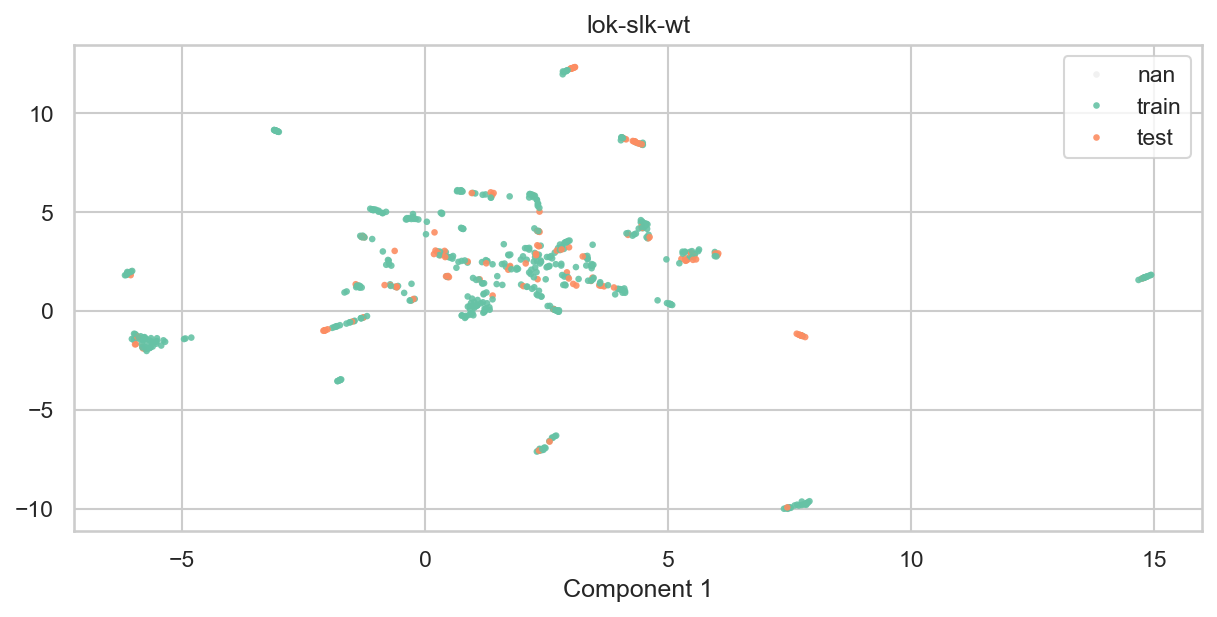

In [7]:
from utils.docs_utils import visualize_split_chemspace

fig = visualize_split_chemspace(
    mols=dataset.table[mol_col].to_list(),
    train_test_dict={"lok-slk-wt": scaffold_split},
)

# export the figure to remote path
from utils.auroris_utils import save_image

save_image(fig, dm.fs.join(FIGURE_DIR, f"lok-slk-wt_{split_key}_chemspace.png"))

## Single task for LOK, SLK with scaffold split 

**Regression tasks**

In [8]:
data_cols = ["LOK", "SLK"]
benchmark_version = "v3"
benchmark_name = f"pkis2-lok-slk-reg-{benchmark_version}"
readme_name = "pkis2-lok-slk-reg"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"


benchmark_reg = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    target_types={col: "regression" for col in data_cols},
    input_cols=mol_col,
    split=scaffold_split,
    main_metric="mean_squared_error",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    tags=["Kinase", "HitDiscovery", "Selectivity", "Multitask"],
    description="Multitask regression benchmark for LOK and SLK wild type.",
    owner=owner,
    readme=load_readme(
        f"org-Polaris/drewry2017_pkis2_subset/benchmarks/readme/040_pkis2-lok-slk_reg_readme.md"
    ),
)
path = benchmark_reg.to_json(BENCHMARK_SAVE_DIR)
print(path)

2024-07-30 13:52:18.709 | INFO     | polaris.mixins._checksum:md5sum:27 - Computing the checksum. This can be slow for large datasets.
2024-07-30 13:52:18.715 | INFO     | polaris.mixins._checksum:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-polaris/drewry2017_pkis2_subset/benchmarks/pkis2-lok-slk-reg-v3/benchmark.json


In [10]:
# Upload to hub
benchmark_reg.upload_to_hub(owner=owner, access="private")

✅ SUCCESS: Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/polaris/pkis2-lok-slk-reg-v3
 


{'id': 'M2pJF2FTyZqNWwMbvUXuo',
 'createdAt': '2024-07-30T17:53:03.054Z',
 'deletedAt': None,
 'name': 'pkis2-lok-slk-reg-v3',
 'slug': 'pkis2-lok-slk-reg-v3',
 'description': 'Multitask regression benchmark for LOK and SLK wild type.',
 'tags': ['Kinase', 'HitDiscovery', 'Selectivity', 'Multitask'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': '0.7.9',
 'readme': '![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-fox-60-kinases.png)\n\n### Background\n**LOK** (STK10) is involved in multiple signaling pathways, including the p38 mitogen-activated protein kinase (MAPK) pathway. \nresearch on STK10 as a therapeutic target was still in its early stages. Preclinical studies in cell lines and animal models might have been conducted to investigate the effects of STK10 inhibition on tumor growth and other cellular processes\n\n**SLK** (STE20-like kinase) is a serine/threonine kinase that belongs to the STE20 family of kinases. It p

**Classification tasks**

In [11]:
data_cols = ["CLS_LOK", "CLS_SLK"]
benchmark_name = f"pkis2-lok-slk-cls-{benchmark_version}"
BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"

benchmark_cls = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="MOL_smiles",
    split=scaffold_split,
    main_metric="pr_auc",
    metrics=["accuracy", "f1", "roc_auc", "pr_auc", "mcc", "cohen_kappa"],
    tags=["kinase", "hit-discovery"],
    description="Multitask classification benchmark for LOK and SLK wild type.",
    owner=owner,
    readme=load_readme(
        f"org-Polaris/drewry2017_pkis2_subset/benchmarks/readme/041_pkis2-lok-slk_clf_readme.md"
    ),
)
path = benchmark_cls.to_json(BENCHMARK_SAVE_DIR)
print(path)

2024-07-30 13:53:04.930 | INFO     | polaris.mixins._checksum:md5sum:27 - Computing the checksum. This can be slow for large datasets.


gs://polaris-public/polaris-recipes/org-polaris/drewry2017_pkis2_subset/benchmarks/pkis2-lok-slk-cls-v3/benchmark.json


In [12]:
# Upload to hub
benchmark_cls.upload_to_hub(owner=owner, access="private")

✅ SUCCESS: Your benchmark has been successfully uploaded to the Hub. View it here: https://polarishub.io/benchmarks/polaris/pkis2-lok-slk-cls-v3
 


/Users/lu.zhu/miniconda3/envs/po_dataset/lib/python3.12/site-packages/yaspin/core.py:228: UserWarning: color, on_color and attrs are not supported when running in jupyter
  self._color = self._set_color(value) if value else value


{'id': '6Pv0QRJUFgma05GlEjyo6',
 'createdAt': '2024-07-30T17:53:09.959Z',
 'deletedAt': None,
 'name': 'pkis2-lok-slk-cls-v3',
 'slug': 'pkis2-lok-slk-cls-v3',
 'description': 'Multitask classification benchmark for LOK and SLK wild type.',
 'tags': ['kinase', 'hit-discovery'],
 'userAttributes': {},
 'access': 'private',
 'isCertified': False,
 'polarisVersion': '0.7.9',
 'readme': '![molprop](https://storage.googleapis.com/polaris-public/icons/icons8-fox-60-kinases.png)\n\n### Background\n**LOK** (STK10) is involved in multiple signaling pathways, including the p38 mitogen-activated protein kinase (MAPK) pathway. \nresearch on STK10 as a therapeutic target was still in its early stages. Preclinical studies in cell lines and animal models might have been conducted to investigate the effects of STK10 inhibition on tumor growth and other cellular processes\n\n**SLK** (STE20-like kinase) is a serine/threonine kinase that belongs to the STE20 family of kinases. It plays a role in various 